# Compare heat exchanger usage to channels 1 to 4




In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from copy import deepcopy
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact
import ipywidgets as widgets
from plotly.offline import iplot

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_tlogger
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, carpet_plot_with_gaps, add_nan_val_in_datagaps, statistic_plot, plot_water_rise, diff_to_watertank, create_mask_egrt
%load_ext autoreload
%autoreload 2

plot_save=True #True False
masterthesis_save = False #True False
compare_to_egrt=True #True False; at the end of this notebook

path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
importer = "pickle" #at the moment everything is imported with pickle

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# pandas version: 1.2.3
# pickle version: 4.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [ ]:
# these are the values in meter, also used in other plots for coloring
begin_borehole_0 = 506 #begin first round in shaft
end_borehole_0   = 1205

begin_borehole_1 = 2209 #begin second round in shaft
end_borehole_1   = 2908

In [5]:
def calc_power_from_T_flow(flow_series, temp_series_RL, temp_series_VL):
    """return work in kW
    Leistungsabgriff, allerdings nicht gleich der Leistung, die der Wärmetauscher zum heizen zur Verfügung stellt
    """
    # density and specific heat capacity values
    # https://www.engineeringtoolbox.com/specific-heat-capacity-water-d_660.html
    # https://www.engineeringtoolbox.com/water-density-specific-weight-d_595.html

    # check if all have the same index
    if (flow_series.index==temp_series_RL.index).all() and (flow_series.index==temp_series_VL.index).all():
        pass
    else:
        print("warning: different indexes of the input series")

    mass_flow=flow_series* 997.541 # [m3/h * kg/m3] = [kg/h] #Dichte bei 23 °C
    temp_diff=temp_series_RL - temp_series_VL
    energy_flow=mass_flow*temp_diff*4.180 #[kg/h * K * kJ/(kg*K)] [kJ/h]
    work=energy_flow/60/60 #[kJ/s = kW]
    work.name="power"

    return work.round(2)

In [6]:
# Load pickle Data
#if using all data this variable is over 2Gb.
data_ch14_constshifted = read_pickle(path_DTS_processed + "\import_data_scripts\data_ch1-4_processed_constshifted")

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_DTS_processed + f"\\shaft_temperatures\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_DTS_processed + r"\shaft_temperatures\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

# import my tlogger
df_Tlogger, df_Tlogger_PT1000 = import_tlogger(path_DTS_processed=path_DTS_processed,importer=importer)

# watertank_T_range_min = df_Tlogger.index.min()
# watertank_T_range_max = df_Tlogger.index.max()

# 2019 heating phase

In [7]:
# Import heat exchanger 2019 operating monitoring
# sek: heating in building (warmer)
# prim: heat exchanger (colder)

# # older version of the data
# xl_file = pd.ExcelFile(path_to_my_database + "\wärmepumpe_betrieb\WP_2018-1019.xlsx")

# df_wp_flow = pd.read_excel(xl_file, sheet_name="WP Durchfluss")
# df_wp_flow.index=pd.to_datetime(df_wp_flow["Zeitstempel"])
# df_wp_flow.sort_index(inplace=True)
# df_wp_flow = df_wp_flow.drop(["Zeitstempel","WP_WMZ_sek_Flow"], axis=1)

# df_wp_temp = pd.read_excel(xl_file, sheet_name="WP Temperaturen")
# df_wp_temp.index=pd.to_datetime(df_wp_temp["Zeitstempel"])
# df_wp_temp = df_wp_temp.drop(["Zeitstempel","WP_VL_Temp_Heizseite","WP_RL_Temp_Heizseite"],axis=1)
# df_wp_temp.sort_index(inplace=True)
# # difference of in and out temperature
# # an estimation of how much heat is extracted
# df_wp_temp["Difference_VL-RL"] = df_wp_temp["WP_VL_Temp_Soleseite"] - df_wp_temp["WP_RL_Temp_Soleseite"]


# newer version of the data
# some dates at beginning are skipped, therfore more at the end compared to other one
# created by Daniel, he created this from the raw data on sciebo. Archiv, Hree, Probebetrieb
df_wp_daniel_2019=pd.read_csv(path_DTS_processed + "\..\Eneregticon_EWS_Data\wärmepumpe_betrieb\WP-Data_2019_02-2019_06_Rohdaten.csv",delimiter=";",index_col=[0]) #dtype already is float
df_wp_daniel_2019.index=pd.to_datetime(df_wp_daniel_2019.index,dayfirst=True)
df_wp_daniel_2019=df_wp_daniel_2019.sort_index()
df_wp_daniel_2019.columns=["WP_VL_Temp_Soleseite [°C]","WP_RL_Temp_Soleseite [°C]","WP_WMZ_prim_Flow [m3/h]"]
df_wp_daniel_2019["power [kW]"]=calc_power_from_T_flow(df_wp_daniel_2019["WP_WMZ_prim_Flow [m3/h]"],df_wp_daniel_2019["WP_RL_Temp_Soleseite [°C]"],
                                                        df_wp_daniel_2019["WP_VL_Temp_Soleseite [°C]"])



# resample so they have the same rows as dts data
sample_hours=3
df_wp_daniel_2019["Difference_VL-RL [K]"]=df_wp_daniel_2019["WP_VL_Temp_Soleseite [°C]"] - df_wp_daniel_2019["WP_RL_Temp_Soleseite [°C]"]
df_wp_daniel_2019_resample = df_wp_daniel_2019.iloc[930:].resample(f"{sample_hours}H").mean()
df_wp_daniel_2019_resample=round(df_wp_daniel_2019_resample,2)
df_wp_daniel_2019_resample

WP_VL_Temp_Soleseite [°C]  WP_RL_Temp_Soleseite [°C]  \
Zeitstempel                                                                 
2019-02-12 09:00:00                      23.55                      18.58   
2019-02-12 12:00:00                      23.40                      19.86   
2019-02-12 15:00:00                      23.51                      21.01   
2019-02-12 18:00:00                      23.52                      20.24   
2019-02-12 21:00:00                      23.32                      19.23   
...                                        ...                        ...   
2019-06-12 18:00:00                      24.41                      23.91   
2019-06-12 21:00:00                      24.48                      24.01   
2019-06-13 00:00:00                      24.29                      22.65   
2019-06-13 03:00:00                      24.30                      23.54   
2019-06-13 06:00:00                      24.04                      21.96   

                     WP_WMZ_prim_Flow [m3/h]  power [kW]  Difference_VL-RL [K]  
Zeitstempel                                                                     
2019-02-12 09:00:00                    12.38      -71.19                  4.96  
2019-02-12 12:00:00                     8.73      -50.51                  3.53  
2019-02-12 15:00:00                     8.68      -35.91                  2.50  
2019-02-12 18:00:00                     8.64      -47.14                  3.28  
2019-02-12 21:00:00                     9.61      -58.66                  4.09  
...                                      ...         ...                   ...  
2019-06-12 18:00:00                     0.00        0.00                  0.50  
2019-06-12 21:00:00                     0.00        0.00                  0.47  
2019-06-13 00:00:00                     2.95      -16.57                  1.64  
2019-06-13 03:00:00                     0.00        0.00                  0.76  
2019-06-13 06:00:00                     5.93      -26.01                  2.07  

[968 rows x 5 columns]

In [8]:
# resample dts data so they have same rows as wp data
# sample_hours defined before
def resample_dts_for_heating_phase(shaft=shaft,from_iloc=0,to_iloc=8788):
    """"""
    shaft_nan={}
    data_dts_resample={}
    for c in ["1","2","3","4"]: #shorten to needed time space
        shaft_nan[c]=shaft[c][from_iloc:to_iloc]
        shaft_nan[c] = add_nan_val_in_datagaps(shaft_nan[c])
        data_dts_resample[c]=shaft_nan[c].resample(f"{sample_hours}H").mean()
        data_dts_resample[c]=round(data_dts_resample[c],2)
    #data_dts_resample["3"]
    return data_dts_resample

# shaft=data_ch14_constshifted also works, some of the labes dont fit then
# using this data shows that outside the shaft the correlation can be seen much less
data_dts_resample=resample_dts_for_heating_phase(shaft=shaft,from_iloc=0,to_iloc=8788)

#check index
for c in ["1","2","3","4"]:
    if (data_dts_resample["1"].index == df_wp_daniel_2019_resample.index).all():
        pass
    else:
        print(f"indes not equal; channel {c}")

951 dates with nan have been added
951 dates with nan have been added
951 dates with nan have been added
951 dates with nan have been added


In [9]:
# Diff between channels (Vor und Rücklauf) better shows influence of hetpump
def diff_channels_for_heating_analysis(df_resample):
    """"""
    df_diff_output={}
    col=df_resample["2"].columns #shorter columns
    for chan in [["1","2"],["1","3"],["1","4"],["3","2"],["2","4"],["3","4"]]:
        # interessanten sind 1 - 4 1 -2 3 - 4 3-2
        chan1 = df_resample[chan[0]]
        chan2 = df_resample[chan[1]]

        df_diff_output[f"{chan[0]} - {chan[1]}"]=chan1 - chan2.set_index(chan1.index)
        df_diff_output[f"{chan[0]} - {chan[1]}"]=df_diff_output[f"{chan[0]} - {chan[1]}"][col] #no nan values at the end
    return df_diff_output

data_dts_resample_diff=diff_channels_for_heating_analysis(data_dts_resample)

bottom plot shows temp of 3 - 4


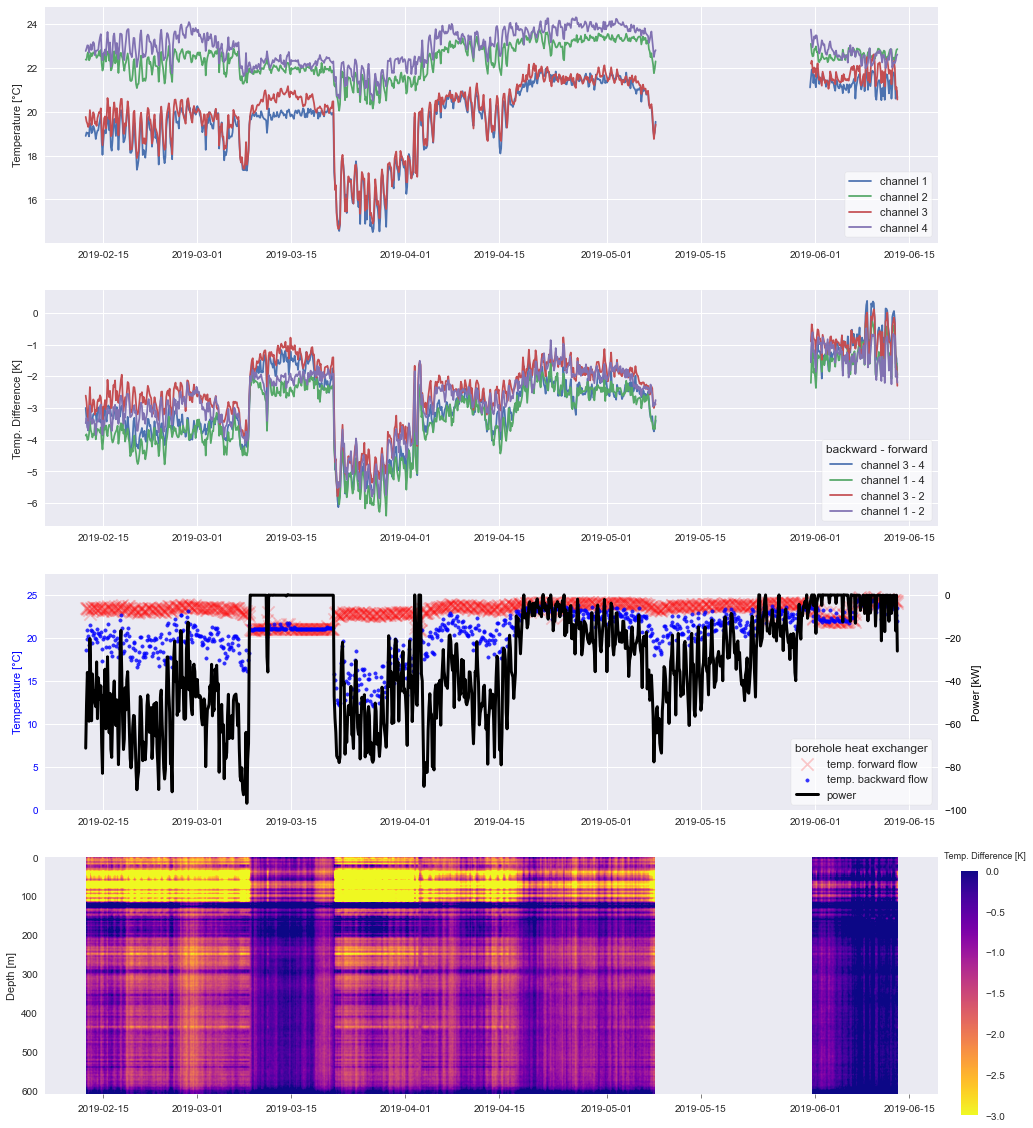

all data is resampled to 3 hours
DTS data from depth 75 m


In [10]:
# plot all const shift data compared to heat exchanger monitoring

def big_plot_heat_exchanger_compare(data_1st_axes=data_dts_resample,data_diff=data_dts_resample_diff,ews_data=df_wp_daniel_2019_resample,data_type_carpet="diff",depth=75,
                                    save_this_plot=False,plot_save=plot_save,sample_hours=sample_hours,save_name="default_name"):
    """
    data_type_carpet="diff" #"diff" "normal"
    """
    fig, axs = plt.subplots(4,1,figsize=[16,20])
    ################################### 1st axes
    ax_number=0
    channels=["1","2","3","4"]
    ylabel="Temperature [°C]"
    for c in channels:
        inde=data_1st_axes[c][depth].index
        val=data_1st_axes[c][depth].values
        axs[ax_number].plot(inde,val, label=f"channel {c}")
    #axs[0].vlines(pd.to_datetime("2020-11-24 12:00:00"),22,26,color="black",label="Wireline 2020")
    #axs[0].plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")

    #axs[1].plot(temp_diff_rolling, label="temp diff in heat exchanger circiut")

    axs[ax_number].set_ylabel(ylabel)
    legend=axs[ax_number].legend(fontsize=11, frameon=True ,title_fontsize=12,loc="lower right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

    ################################### 2nd axes
    ax_number=1
    channels=["3 - 4","1 - 4","3 - 2","1 - 2"]
    ylabel="Temp. Difference [K]"
    for c in channels:
        inde=data_diff[c][depth].index
        val=data_diff[c][depth].values
        axs[ax_number].plot(inde,val, label=f"channel {c}")
    #axs[0].vlines(pd.to_datetime("2020-11-24 12:00:00"),22,26,color="black",label="Wireline 2020")
    #axs[0].plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank"], label="Watertank")

    #axs[1].plot(temp_diff_rolling, label="temp diff in heat exchanger circiut")

    axs[ax_number].set_ylabel(ylabel)
    legend=axs[ax_number].legend(fontsize=11, frameon=True ,title_fontsize=12,loc="lower right",title="backward - forward")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")
    axs[ax_number].sharex(axs[0])


    ##################################### 3nd axes
    ax_number=2
    ymin_2nd_axses_temp=0
    ymax_2nd_axses_temp=27.5
    ymin_2nd_axses_power=-100
    ymax_2nd_axses_power=10
    cpower="black"
    cRL="blue"
    cVL="red"
    size_temp=100

    axs[ax_number].scatter(ews_data["WP_VL_Temp_Soleseite [°C]"].index,ews_data["WP_VL_Temp_Soleseite [°C]"].values,
            label="temp. forward flow", color=cVL,alpha=0.2,s=size_temp*1.5,marker="x")
    axs[ax_number].scatter(ews_data["WP_RL_Temp_Soleseite [°C]"].index,ews_data["WP_RL_Temp_Soleseite [°C]"].values,
            label="temp. backward flow", color=cRL,alpha=0.8,s=size_temp/2,marker=".")
    axs[ax_number].set_ylim(ymin_2nd_axses_temp,ymax_2nd_axses_temp)
    axs[ax_number].tick_params(axis='y', labelcolor=cRL)
    axs[ax_number].set_ylabel("Temperature [°C]", color=cRL)

    axs1_0=axs[ax_number].twinx()
    axs1_0.plot(ews_data["power [kW]"], label="power",color=cpower,linewidth=3)
    axs1_0.set_ylabel('Power [kW]', color=cpower)
    axs1_0.set_ylim(ymin_2nd_axses_power,ymax_2nd_axses_power) # both y-axis have similar scale --> helper lines are alligned
    # The grids are not alligned, if not using .set_ylim()
    axs1_0.tick_params(axis='y', labelcolor=cpower)
    axs1_0.grid(None) #axs is behind the helper lines

    lines, labels = axs[ax_number].get_legend_handles_labels()
    lines2, labels2 = axs1_0.get_legend_handles_labels()
    legend=axs[ax_number].legend(lines + lines2, labels + labels2,fontsize=11, frameon=True ,title_fontsize=12,title="borehole heat exchanger", loc="lower right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")
    axs[ax_number].sharex(axs[0])

    ############################################################# 4rd axes Carpet Plot
    ax_number=3
    if data_type_carpet=="diff":
        chan="3 - 4" #"1 - 4","3 - 2","1 - 2"
        vmin=-3
        vmax=0
        data_carpet=data_diff[chan]
    elif data_type_carpet=="normal":
        chan="1" #"2","3","4"
        vmin=21
        vmax=25
        data_carpet=data_1st_axes[chan]
    print(f"bottom plot shows temp of {chan}")

    depth_carpet=data_carpet.columns
    date = data_carpet.index.to_series()
    # Datum-Ticks auf x-Achse und Farbskala
    starti = depth_carpet[0]
    stopi = depth_carpet[-1]
    xax3 = mdates.date2num(date)
    xstart = xax3[0]
    xstop  = xax3[-1]

    axs[ax_number].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
    caxa = axs[ax_number].imshow(data_carpet.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                    cmap = 'plasma_r', aspect = 'auto', vmin = vmin, vmax = vmax)
    #PiYG
    axs[ax_number].set_ylabel("Depth [m]")
    axs[ax_number].tick_params(axis="x", which='both',length=4,color="grey")
    cbax = fig.add_axes([0.92, 0.11, 0.015, 0.17])
    cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
    cbar.set_label(ylabel, rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
    axs[ax_number].tick_params(axis = 'x', labelrotation = 0)
    axs[ax_number].xaxis_date()
    date_format = mdates.DateFormatter('%Y-%m-%d')
    axs[ax_number].xaxis.set_major_formatter(date_format)
    axs[ax_number].sharex(axs[0])

    if plot_save and depth==75 and save_this_plot:
        if save_name == "\\compare_to_BHE_usage_all_bigplot" and masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix" + save_name + ".pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster" + save_name + ".png", format="png",bbox_inches="tight",dpi=300)
            print("plot saved")
        elif save_name == "\\compare_to_BHE_usage_2019_bigplot" and masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4" + save_name + ".pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4" + save_name + ".png", format="png",bbox_inches="tight",dpi=300)
            print("plot saved")
        plt.savefig(r".\pictures" + save_name +".png",bbox_inches="tight")    
    plt.show()
    print(f"all data is resampled to {sample_hours} hours")
    print(f"DTS data from depth {depth} m")




big_plot_heat_exchanger_compare(data_1st_axes=data_dts_resample,data_diff=data_dts_resample_diff,ews_data=df_wp_daniel_2019_resample,depth=75,save_this_plot=True,save_name="\\compare_to_BHE_usage_2019_bigplot")


#kanal 3 und 4 zeigen Korreltation zu Rücklauf temperatur (entgegengesetzt)
    #3 wird wärmer bei stopp --> RL
    #4 wird kälter bei stopp --> VL

# kanal 1 und 2 zeigen kaum Änderrungen, wie Vorlauf Temperatur? 
    #Nicht so nah am Rohr, andere Seite im Kabel? die Wasser zugewnat ist?

# somit wären kanal 1 und 4 an einer glasfaser
# 2 und 3 an der anderen

In [11]:
def plot_power_and_single_difference_plotly(df_plot=df_wp_daniel_2019_resample,df_diff=data_dts_resample_diff,depth=250,from_date=205,to_date=-550,show_all_diffs_dts=False,save_this_plot=False,save_name="default_name"):
    """from_date; to_date: these are for saving a plot, if only looking use 0, -1 and zoom"""

    #power
    trace0 = go.Scatter(x=df_plot["power [kW]"].index[from_date:to_date],
        y=df_plot["power [kW]"].values[from_date:to_date],
        name='heat pump power [kW]',
        yaxis='y',
        fillcolor="black",
        line={"color":"black","dash":"solid","width":3},)
    #DTS temp

    if show_all_diffs_dts:
        cmap=px.colors.qualitative.Vivid[1:-2]
        trace1 = go.Scatter(x=df_diff["3 - 4"][depth].index[from_date:to_date],y=df_diff["3 - 4"][depth].values[from_date:to_date],
            name='DTS channel 3 - 4',
            yaxis='y',
            line={"dash":"solid","width":3,"color":cmap[0]},
           )
        trace2 = go.Scatter(x=df_diff["1 - 4"][depth].index[from_date:to_date],y=df_diff["1 - 4"][depth].values[from_date:to_date],
            name='DTS channel 1 - 4',
            yaxis='y',
            line={"dash":"solid","width":3,"color":cmap[1]},
            )
        trace3 = go.Scatter(x=df_diff["3 - 2"][depth].index[from_date:to_date],y=df_diff["3 - 2"][depth].values[from_date:to_date],
            name='DTS channel 3 - 2',
            yaxis='y',
            line={"dash":"solid","width":3,"color":cmap[-2]},
            )
        trace4 = go.Scatter(x=df_diff["1 - 2"][depth].index[from_date:to_date],y=df_diff["1 - 2"][depth].values[from_date:to_date],
            name='DTS channel 1 - 2',
            yaxis='y',
            line={"dash":"solid","width":3,"color":cmap[-1]},
            )
    else: #onnly show one diff
        trace1 = go.Scatter(x=df_diff["3 - 2"][depth].index[from_date:to_date],y=df_diff["3 - 4"][depth].values[from_date:to_date],
            name='DTS channel 3 - 2',
            yaxis='y',
            fillcolor="blue",
            line={"color":"blue","dash":"solid","width":3},)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(trace0)
    if show_all_diffs_dts:
        fig.add_trace(trace1,secondary_y=True)
        fig.add_trace(trace2,secondary_y=True)
        fig.add_trace(trace3,secondary_y=True)
        fig.add_trace(trace4,secondary_y=True)
    else:
        fig.add_trace(trace1,secondary_y=True)
    fig.update_yaxes(title_text="Power [kW]", secondary_y=False,range=[-100,10])
    fig.update_yaxes(title_text="Temp. Difference [K]",color="blue", secondary_y=True,range=[-5,0.5])
    fig.update_layout(legend={"yanchor":"bottom","xanchor":"left","y":0.05,"x":0.01})

    if save_this_plot and masterthesis_save and plot_save and depth==250 and from_date==205 and to_date==-550 and save_name=="\\compare_ch14_to_power_2019":
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4" + save_name + ".pdf",width=1120, height=500)
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4" + save_name + ".png",width=1120, height=500)
    elif save_this_plot and masterthesis_save and plot_save and depth==250 and from_date==0 and to_date==-1 and save_name=="\\compare_ch14_to_power_2020":
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4" + save_name + ".pdf",width=1120, height=500)
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4" + save_name + ".png",width=1120, height=500)
    fig.show()

    print(f"from a depth of {depth} m")

plot_power_and_single_difference_plotly(df_plot=df_wp_daniel_2019_resample,df_diff=data_dts_resample_diff,save_this_plot=True,show_all_diffs_dts=True,save_name="\\compare_ch14_to_power_2019",
                                depth=250,from_date=205,to_date=-550) #saved with: depth==250, from_date==205, to_date==-550

from a depth of 250 m


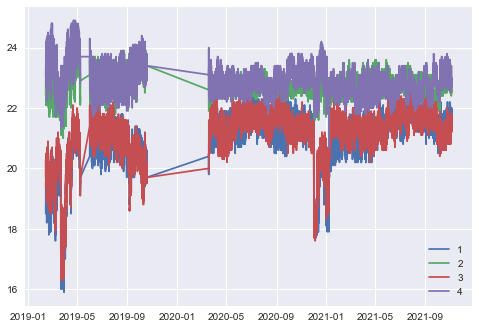

In [12]:
# alle channel im shaft at one depth
for chan in ["1","2","3","4"]:
    plt.plot(shaft[chan][70],label=f"{chan}")
plt.legend()
plt.show()

In [13]:
def interactive_plot_function(iloc,aver_dates):
    fig = make_subplots(rows=2,cols=2,
                        specs=[[{}, {}],[{"colspan": 2}, None]],
                        subplot_titles=("backward flow","forward flow", None),shared_xaxes=True,shared_yaxes=True)
    # 1st axes
    for chan in ["1","2","3","4"]:
        if chan in ["1","3"]:
            col=1
        elif chan in ["2","4"]:
            col=2
        # average multiple dates
        data=round(data_dts_resample[chan].iloc[iloc:iloc+aver_dates].mean(axis=0),2)
        fig.add_trace(
            go.Scatter(x=data.values,y=data.index,name=f"channel {chan}",line={"dash":"solid","width":1},yaxis="y",xaxis="x"),
            row=1,col=col)
    # bottom axes
    fig.add_trace(
            go.Scatter(x=df_wp_daniel_2019_resample["power [kW]"].index,y=df_wp_daniel_2019_resample["power [kW]"].values,opacity=0.5,
                        name="power [kW]",line={"dash":"solid","width":2,"color":"orange"}),
            row=2,col=1)

    fig.add_shape(type="line", x0=data_dts_resample["1"].iloc[iloc].name.to_pydatetime(), y0=0, x1=data_dts_resample["1"].iloc[iloc].name.to_pydatetime(), y1=-100,
                    name="used date",
                    line=dict(color="black",width=2,dash="solid",),
                    row=2, col=1,)
    fig.add_shape(type="line", x0=data_dts_resample["1"].iloc[iloc+aver_dates].name.to_pydatetime(), y0=0, x1=data_dts_resample["1"].iloc[iloc+aver_dates].name.to_pydatetime(), y1=-100,
                    name="used date",
                    line=dict(color="black",width=2,dash="solid",),
                    row=2, col=1,)

    # Accesoirs
    for col in [1,2]:
        fig.update_xaxes(title_text="Temperature [°C]",range=[20,26],row=1,col=col,matches='x')
        fig.update_yaxes(title_text="Depth [m]",range=[890,0],row=1,col=col)
    fig.update_yaxes(range=[-100,0],row=2,col=1,color="grey") #title_text="Power [kW]"
    fig.update_xaxes(row=2,col=1,color="grey")
    fig.update_layout(height=700, width=1120,
                        legend={"yanchor":"bottom","xanchor":"left","y":0.18,"x":0.45,"bordercolor":"Black","borderwidth":1},
                        yaxis_showticklabels=True, yaxis2_showticklabels=True,
                        yaxis=dict(domain=[0.3, 1]),yaxis2=dict(domain=[0.3, 1]),yaxis3=dict(domain=[0, 0.13]),#size of plots
                        )

    date_prin1=str(data_dts_resample["1"].iloc[iloc].name.to_pydatetime())[5:-3]
    date_prin2=str(data_dts_resample["1"].iloc[iloc+aver_dates-1].name.to_pydatetime())[5:-3] #-1 because last date is not used for averaging
    if aver_dates!=1:
        print(f"time range of upper plots:\n{date_prin1} to {date_prin2} 2019")
    else:
        print(f"date: {date_prin1} 2019")

    # only needed for my thesis
    # if adjusting interact, this is saved too
    save_this_plot=False
    if save_this_plot and plot_save and iloc==225 and aver_dates==60 and masterthesis_save:
        print("plot saved")
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix" + "\\2019_backward_forward_average_ews_off" + ".pdf",width=1120, height=500)
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster" + "\\2019_backward_forward_average_ews_off" + ".png",width=1120, height=500)
    elif save_this_plot and plot_save and iloc==405 and aver_dates==60 and masterthesis_save:
        print("plot saved")
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix" + "\\2019_backward_forward_average_ews_on" + ".pdf",width=1120, height=500)
        fig.write_image(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster" + "\\2019_backward_forward_average_ews_on" + ".png",width=1120, height=500)
    iplot(fig)


In [14]:
# Wie lange ist Wasser des BHE im Schacht:
# Durchfluss Sonde
A=np.pi*(0.075/2)**2 #[m^2]
# Volumen BHE im gesammten Schacht
V=A*860*2 #[m^3]

# SOnde laäuft stark dann ca. 12 m^3/h
# df_wp_daniel_2019_resample["WP_WMZ_prim_Flow [m3/h]"][100:] #flow info 
Q=12.3
t=V/Q #[h]
print(f"water of the BHE is {round(t*60,2)} min. in the shaft, when the flow is high") 
V

water of the BHE is 37.07 min. in the shaft, when the flow is high


7.598727230870312

In [15]:
iloc_both=[290,300]

diff={}
for chan in ["1","2","3","4"]:
    data_1=round(data_dts_resample[chan].iloc[iloc_both[0]:iloc_both[0]+10].mean(axis=0),2)
    data_2=round(data_dts_resample[chan].iloc[iloc_both[1]:iloc_both[1]+10].mean(axis=0),2)
    # diff[chan]=data_1-data_2
    diff[chan]=data_2-22


no heat pump use - heat pump use
forward


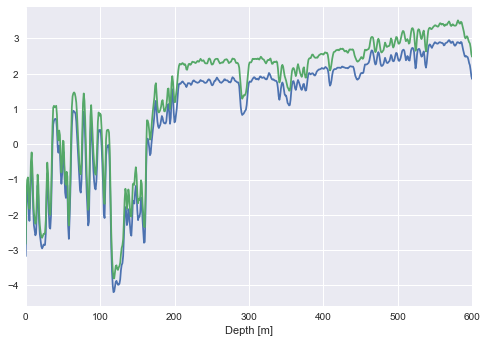

backward


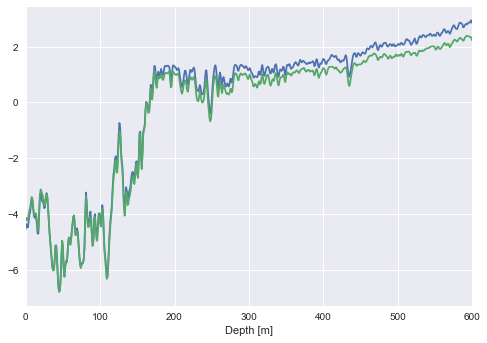

In [16]:
print("no heat pump use - heat pump use")
print("forward")
for chan in ["2","4"]:
    plt.plot(diff[chan])
plt.xlim(0,600)
# plt.ylim(-1,4)
plt.xlabel("Depth [m]")
plt.show()
print("backward")
for chan in ["1","3"]:
    plt.plot(diff[chan])
plt.xlim(0,600)
# plt.ylim(-1,4)
plt.xlabel("Depth [m]")
plt.show()


# forward ist das was am meisten erwärmt ist,
# peaks zeigen am ehesten die pipe temp an 

# pos differenz bedeutet noch nicht genug erwärmt

# Erkenne keinen eindeutigen Zusammenhang der die Erwärmung des Wasser im BHE entlang der Schachts beschreibt ...

# tiefen raus nehmen bei denen ich behaupte die spiegeln die BHE temp am besten wieder 
# über die Zeit beobachten, 
# evntl nach heat pump stopp diff änderrung beobachten

In [17]:
col=data_dts_resample["2"].columns[289:298]
data_dts_resample["2"][col]

Depth [m]              289    290    291    292    293    294    295    296  \
2019-02-12 09:00:00  23.20  23.06  23.00  22.97  23.03  23.04  23.10  23.16   
2019-02-12 12:00:00  23.19  23.09  23.06  23.08  23.13  23.17  23.20  23.21   
2019-02-12 15:00:00  23.34  23.25  23.21  23.23  23.28  23.29  23.36  23.41   
2019-02-12 18:00:00  23.43  23.33  23.30  23.35  23.39  23.35  23.38  23.46   
2019-02-12 21:00:00  23.16  23.05  23.05  23.06  23.07  23.08  23.11  23.13   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2019-06-12 18:00:00  24.04  24.00  24.03  24.07  24.07  24.02  24.02  24.01   
2019-06-12 21:00:00  23.97  23.98  24.01  23.98  23.98  23.98  23.98  23.96   
2019-06-13 00:00:00  23.85  23.77  23.80  23.78  23.80  23.79  23.81  23.83   
2019-06-13 03:00:00  23.77  23.75  23.72  23.69  23.73  23.75  23.73  23.75   
2019-06-13 06:00:00  23.65  23.60  23.55  23.50  23.55  23.55  23.50  23.60   

Depth [m]              297  
2019-02-12 09:00:00  23.24  
2019-02-12 12:00:00  23.30  
2019-02-12 15:00:00  23.48  
2019-02-12 18:00:00  23.57  
2019-02-12 21:00:00  23.21  
...                    ...  
2019-06-12 18:00:00  23.98  
2019-06-12 21:00:00  23.95  
2019-06-13 00:00:00  23.88  
2019-06-13 03:00:00  23.77  
2019-06-13 06:00:00  23.65  

[968 rows x 9 columns]

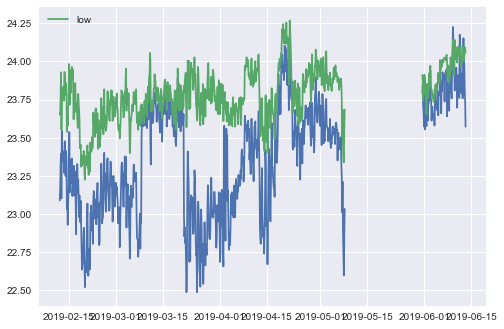

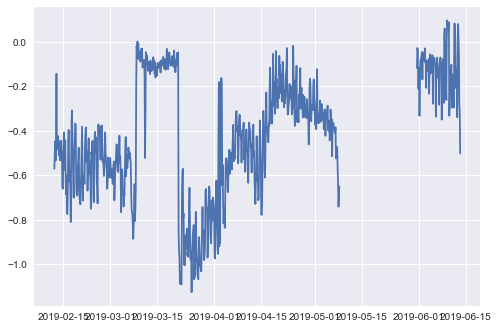

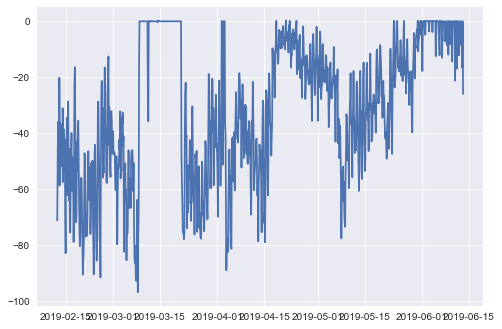

In [18]:
#high sensetive
col=data_dts_resample["2"].columns[289:298]
data_high_sens=data_dts_resample["2"][col].mean(axis=1)
plt.plot(data_high_sens.index,data_high_sens.values)

#low sensetive
col=data_dts_resample["2"].columns[230:250]
col2=data_dts_resample["2"].columns[312:325]
reference_temp_low_sens=pd.concat([data_dts_resample["2"][col],data_dts_resample["2"][col2]],axis=1).mean(axis=1)
plt.plot(reference_temp_low_sens.index,reference_temp_low_sens.values,label="low") 
plt.legend()
plt.show()

#diff
diff=data_high_sens-reference_temp_low_sens
plt.plot(diff.index,diff.values)
plt.show()

# power
plt.plot(df_wp_daniel_2019_resample["power [kW]"].index,df_wp_daniel_2019_resample["power [kW]"].values)
plt.show()


# diff zwitlich konstant, aber umso stärker heat pump läuft umso größer
# das gleiche könnte ich jetzt für alle sensetiven Tiefen machen
# untereinadner vergleichen ist aber nicht Sinnvoll
# oder ich erwähne das einfach nur im Text ohne Abbildung

# für backward auf jeden Fall noch machen

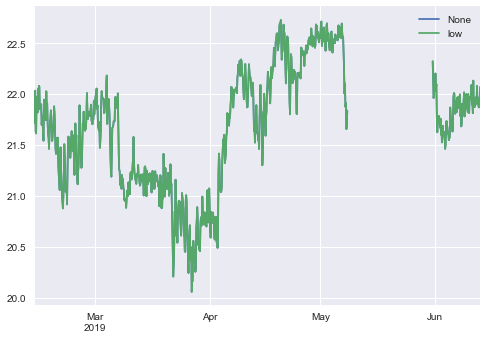

In [19]:
col=data_dts_resample["2"].columns[50:60]
data_dts_resample["2"][col].mean(axis=1).plot() #high sensetive

col=data_dts_resample["2"].columns[50:60]
data_dts_resample["2"][col].mean(axis=1).plot(label="low") #low sensetive
plt.legend()
plt.show()

In [20]:
# Interactive plot of depth dependent temperatures in 2019 heating phase
plotly.offline.init_notebook_mode()

interact(interactive_plot_function,
        iloc=widgets.IntSlider(min=0, max=len(data_dts_resample[chan].index)-1, step=5, value=20,name="date iloc"), #step should correspond to averaging
        aver_dates=widgets.IntSlider(min=1, max=100, step=1, value=10,name="average dates"),)

# print("data belongs to a larger time range due to averageing border +, -respectivly 1.5 h")

# save plot with: iloc==225 and aver_dates==60; iloc==405 and aver_dates==60

interactive(children=(IntSlider(value=20, description='iloc', max=967, step=5), IntSlider(value=10, descriptio…

<function __main__.interactive_plot_function(iloc, aver_dates)>

# heat exchanger comparison energeticon data

In [21]:
# import data from Energeticon server
def import_exc_energeticon_ews_server(path_data_folder,filename_exs):
    xl_file = pd.ExcelFile(path_data_folder + filename_exs)
    df = pd.read_excel(xl_file, sheet_name="Sheet1")
    df.index=pd.to_datetime(df["Time stamp"],dayfirst=True)
    df.index.names=["Date"]
    #df.sort_index(inplace=True)
    df = df.drop(["Time stamp"], axis=1)
    return df

path_data_folder=r"..\Alsdorf\Daten\Eneregticon_EWS_Data\02_Wärmeerzeugung"
# files with detailed data
filename_exs="\\Trendlog-Liste WP Temperaturen.xlsx"
df_ewsserver_temp_detail=import_exc_energeticon_ews_server(path_data_folder,filename_exs)
df_ewsserver_temp_detail.drop(["WP_VL_Temp_Heizseite","WP_RL_Temp_Heizseite"],axis=1,inplace=True)
filename_exs="\\Trendlog-Liste WP Durchfluß.xlsx"
df_ewsserver_flow_detail=import_exc_energeticon_ews_server(path_data_folder,filename_exs)
df_ewsserver_flow_detail.drop(["WP_WMZ_sek_Flow"],axis=1,inplace=True)

# files with larger timegaps but longer time span
filename_exs="\\Trendlog-Liste WP Durchfluss.xlsx"
df_ewsserver_flow_long=import_exc_energeticon_ews_server(path_data_folder,filename_exs)
# df_ewsserver_flow_long.drop(["WP_WMZ_sek_Flow"],axis=1,inplace=True) # sek flow contains more data than prim flow, evntl als Erstz benutzen
df_ewsserver_flow_long_sek=df_ewsserver_flow_long.drop(["WP_WMZ_prim_Flow"],axis=1)
df_ewsserver_flow_long=df_ewsserver_flow_long.drop(["WP_WMZ_sek_Flow"],axis=1)
filename_exs="\\Trenddiagramm Temperaturen Wärmepumpe.xlsx"
df_ewsserver_temp_long=import_exc_energeticon_ews_server(path_data_folder,filename_exs)
# df_ewsserver_temp_long.drop(["WP_VL_Temp_Heizseite","WP_RL_Temp_Heizseite"],axis=1,inplace=True) # sek flow contains more data than prim flow, evntl als Erstz benutzen
df_ewsserver_temp_long_prim=pd.concat([df_ewsserver_temp_long["WP_VL_Temp_Soleseite"],df_ewsserver_temp_long["WP_RL_Temp_Soleseite"]],axis=1)
df_ewsserver_temp_long_sek=pd.concat([df_ewsserver_temp_long["WP_VL_Temp_Heizseite"],df_ewsserver_temp_long["WP_RL_Temp_Heizseite"]],axis=1)

# some processing for all dataframes
# a little bit complicated but maybe its the best solution?
df_list=[df_ewsserver_temp_detail,df_ewsserver_flow_detail,df_ewsserver_flow_long,df_ewsserver_temp_long_prim,df_ewsserver_temp_long_sek,df_ewsserver_flow_long_sek]
counter=0
for df in df_list:
    #print(counter)
    series={}
    # somehow rounding does not work, the nan of pd.to_numeric are strange I think
    for column in df.columns:
        series[column]=df[column].apply(pd.to_numeric,errors="coerce").dropna().round(2)

    df_list[counter]=pd.concat([series[x] for x in series.keys()],axis=1).sort_index()
    df_list[counter].sort_index(inplace=True)
    counter+=1

# keep original variable names and give them transformed dataframe
df_ewsserver_temp_detail=df_list[0]
df_ewsserver_flow_detail=df_list[1]
df_ewsserver_flow_long=df_list[2]
df_ewsserver_temp_long_prim=df_list[3]
df_ewsserver_temp_long_sek=df_list[4]
df_ewsserver_flow_long_sek=df_list[5]

# Calculate power
work_detail=calc_power_from_T_flow(df_ewsserver_flow_detail["WP_WMZ_pri_Flow"], df_ewsserver_temp_detail["WP_RL_Temp_Soleseite"], df_ewsserver_temp_detail["WP_VL_Temp_Soleseite"])

data=df_ewsserver_temp_long_prim["WP_RL_Temp_Soleseite"].iloc[49550:97870] # so it has the same index as flow dataframe
data_resample_RL=data.resample(timedelta(minutes=15)).mean()
data=df_ewsserver_temp_long_prim["WP_VL_Temp_Soleseite"].iloc[49550:97870] # so it has the same index as flow dataframe
data_resample_VL=data.resample(timedelta(minutes=15)).mean()

data=df_ewsserver_flow_long["WP_WMZ_prim_Flow"]
data_resample_flow=data.resample(timedelta(minutes=15)).mean()

work_long=calc_power_from_T_flow(data_resample_flow, data_resample_RL, data_resample_VL)



##########
# does not conatain much data I should only work with the flow data
# ilocs are wrong - need to be adapted
# df_ewsserver_temp_long_sek["WP_VL_Temp_Heizseite"]=np.ones(len(df_ewsserver_temp_long_sek["WP_VL_Temp_Heizseite"].index))*60 #replace the data gaps, not need accurate values anyway
# resample_data_flow_sek_long=df_ewsserver_flow_long_sek.iloc[:].resample(timedelta(hours=5)).mean().iloc[1797:]
# resample_data_temp_sek_long=df_ewsserver_temp_long_sek.iloc[:].resample(timedelta(hours=5)).mean()[:2574]
# resample_data_temp_sek_long.index=resample_data_flow_sek_long.index
# work_long_sek=calc_power_from_T_flow(resample_data_flow_sek_long["WP_WMZ_sek_Flow"], resample_data_temp_sek_long["WP_RL_Temp_Heizseite"], resample_data_temp_sek_long["WP_VL_Temp_Heizseite"])


# put all in two dataframes
df_ews_detail=pd.concat([df_ewsserver_temp_detail,df_ewsserver_flow_detail,work_detail],axis=1)
df_ews_long=pd.concat([df_ewsserver_temp_long_prim.resample(timedelta(minutes=15)).mean(),df_ewsserver_flow_long.resample(timedelta(minutes=15)).mean(),work_long],axis=1)
df_ews_detail.columns=df_ews_long.columns # make column names equal

# delete unecessary variables
del df_ewsserver_temp_detail
del df_ewsserver_flow_detail
del df_ewsserver_flow_long
del df_ewsserver_temp_long
del df_list

# 2020 heating phase

In [22]:
#ende 2020 heatinh phase data seperate dataframe
sample_hours=3

# BHE data for this heating phase
bhe_data_2020_heating=df_ews_long.iloc[74180:75680] #[74180:75680]; rest is nan; temp has more data points
# same column names as heating phase 2019
bhe_data_2020_heating.columns=["WP_VL_Temp_Soleseite [°C]","WP_RL_Temp_Soleseite [°C]","WP_WMZ_prim_Flow [m3/h]","power [kW]"]
bhe_data_2020_heating=bhe_data_2020_heating.resample(f"{sample_hours}H").mean()

# resample and cut to heating time 2020
data_dts_resample_2020heating=resample_dts_for_heating_phase(shaft=shaft,from_iloc=35000,to_iloc=51000) #from_iloc=45355,to_iloc=46761
#check index
check=False
if check:
    for c in ["1","2","3","4"]:
        if (data_dts_resample_2020heating["1"].index == bhe_data_2020_heating.index).all():
            pass
        else:
            print(f"indes not equal; channel {c}")

# calc diff between channels
data_dts_resample_diff_2020heating=diff_channels_for_heating_analysis(data_dts_resample_2020heating)

3 dates with nan have been added
3 dates with nan have been added
3 dates with nan have been added
3 dates with nan have been added


In [23]:
# plot 2020 heating phase with all avaible data
depth=250
plot_power_and_single_difference_plotly(df_plot=bhe_data_2020_heating,df_diff=data_dts_resample_diff_2020heating,save_this_plot=True,show_all_diffs_dts=True,save_name="\\compare_ch14_to_power_2020",
                                        depth=depth,from_date=0,to_date=-1) # saved with depth==250 and from_date==0 and to_date==-1
# shows thaht only for a short period of this heating phase data is avaible
# but heating phase can be monitored with DTS, könnte ich als Fazit nennen, als alternatives monitoring, dann aber noch unterschiede nenen der Monitoring arten #
# unterschiedliche position genauigkeit?

from a depth of 250 m


In [24]:
sample_hours=3
df_ews_long_resample=df_ews_long.resample(f"{sample_hours}H").mean()
df_ews_detail_resample=df_ews_detail.resample(f"{sample_hours}H").mean()

In [25]:
if sample_hours!=3:
    print("adapt values for conat !!!!!!!!!!!!!!!!!!!!!!!!!!")

df_2019_for_all=df_wp_daniel_2019_resample.drop(["Difference_VL-RL [K]"],axis=1)

all_ews_data_resample=pd.concat([df_ews_detail_resample,df_ews_long_resample.iloc[:7913]],axis=0) # df overlap and dont measure the same temeratures
all_ews_data_resample.columns=df_2019_for_all.columns
all_ews_data_resample.sort_index(inplace=True)
all_ews_data_resample=pd.concat([all_ews_data_resample[1712:],all_ews_data_resample[:744],df_2019_for_all],axis=0)
all_ews_data_resample=round(all_ews_data_resample,2)
all_ews_data_resample.sort_index(inplace=True)

In [26]:
resample_all_dts=resample_dts_for_heating_phase(shaft=shaft,from_iloc=0,to_iloc=-1)

diff_all_dts=diff_channels_for_heating_analysis(resample_all_dts)

7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added
7234 dates with nan have been added


bottom plot shows temp of 3 - 4


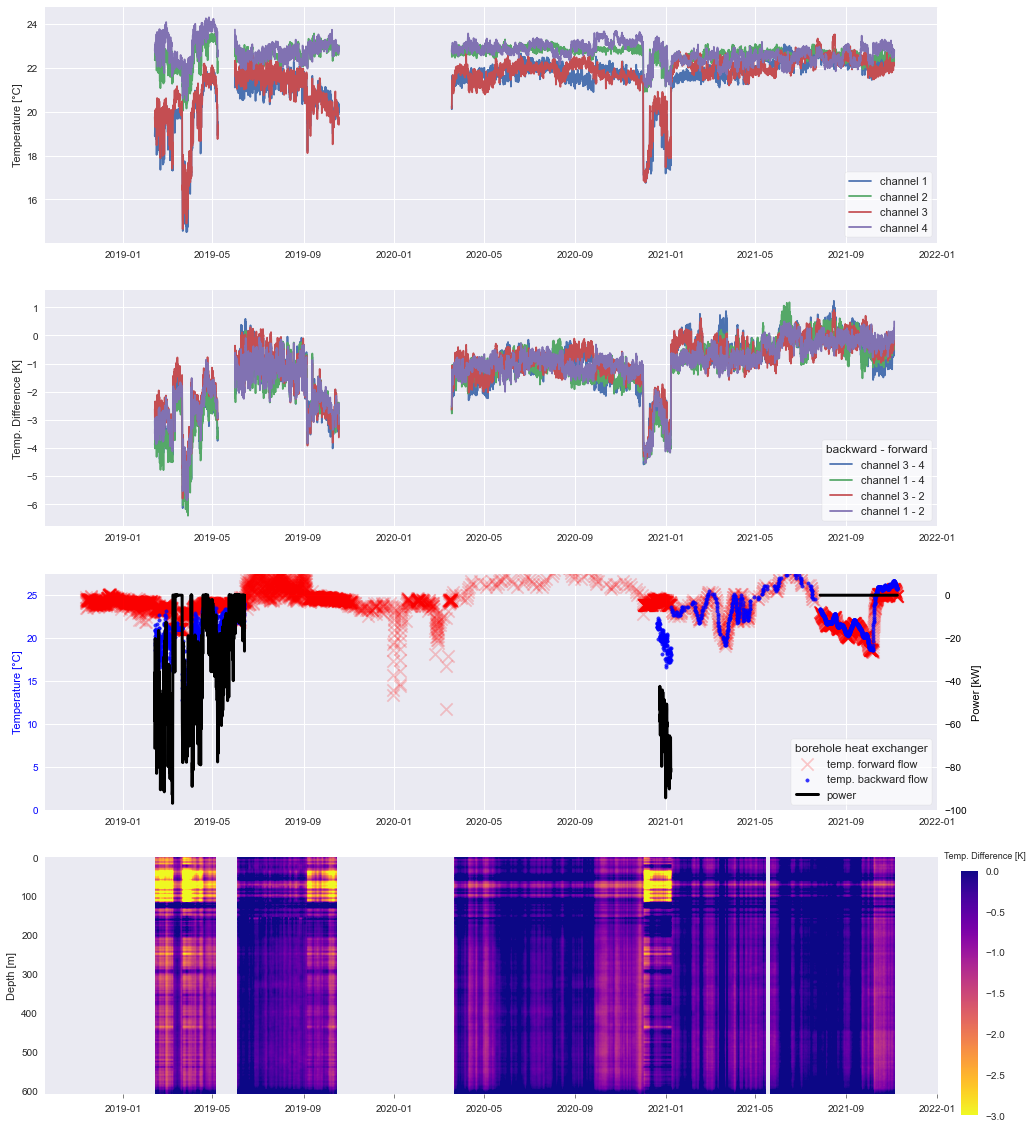

all data is resampled to 3 hours
DTS data from depth 75 m


In [27]:
# big plot for all avaible data

big_plot_heat_exchanger_compare(data_1st_axes=resample_all_dts,data_diff=diff_all_dts,ews_data=all_ews_data_resample,depth=75,save_this_plot=True,save_name="\\compare_to_BHE_usage_all_bigplot")
# saved with: depth=75

## Compare water tank temp and ews temp

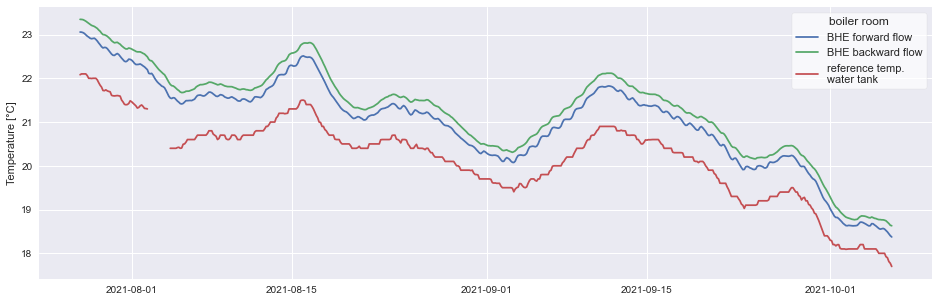

In [28]:
sample_hours=3
tlogger_resample=df_Tlogger["Channel1_rolling_mean"].resample(f"{sample_hours}H").mean()[400:]
ews_detail_resample_RL=df_ews_detail["WP_RL_Temp_Soleseite"].resample(f"{sample_hours}H").mean()[:568]
ews_detail_resample_VL=df_ews_detail["WP_VL_Temp_Soleseite"].resample(f"{sample_hours}H").mean()[:568]

data=[ews_detail_resample_VL,ews_detail_resample_RL,tlogger_resample]
data_labels=["BHE forward flow", "BHE backward flow", "reference temp.\nwater tank"]
fig, axs = plt.subplots(1,1,figsize=[16,5])
for d,l in zip(data,data_labels):
    axs.plot(d.index,d.values,label=f"{l}")

axs.set_ylabel("Temperature [°C]")
legend=axs.legend(fontsize=11, frameon=True ,title_fontsize=12,title="boiler room")
legend.get_frame().set_alpha(0.7)
legend.get_frame().set_facecolor("white")

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\boiling_room_water_temp_compare.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\boiling_room_water_temp_compare.png", format="png",bbox_inches="tight")
    plt.savefig(r".\pictures\boiling_room_water_temp_compare.png",bbox_inches="tight")  
plt.show()

# Analyse Shaft temperature during EGRT

In [29]:
if compare_to_egrt:
    # import solexperts t_logger
    path_to_solexperts = path_DTS_processed + "\..\Solexperts_EGRT"
    filename = "\wagoTemperatur_korigiert.txt"
    tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
    tlogger_sol.columns.names = ["Dates"]
    tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
    tlogger_sol.index=["Watertank"]
    tlogger_sol.index.names = [""]
    tlogger_sol = tlogger_sol.T
    tlogger_sol.columns = ["Watertank_PT1000"] # name is does not fit to this data, just for concat woth my other dataframe

In [30]:
if compare_to_egrt:
    type_plot="normal" #normal diff
    plot_where="Watertank" #Watertank Shaft
    vmin=22
    vmax=26
    sample_hours = 1
    fig, axs = plt.subplots(5,1,figsize=[16,20])

    axs[0].plot(tlogger_sol["Watertank_PT1000"])
    axs[0].set_ylabel("Temperature [°C]")
    axs[0].set_title("Water tank",loc="left")

    for c in ["1","2","3","4"]: #shorten to needed time space
        # in shaft hard to see influence
        if plot_where=="Shaft":
            col=shaft[c][61650:62200].columns[150:450]
            shaft_nan_chan = shaft[c][61650:62200][col]
        
        # water tank heating is visible
        if plot_where=="Watertank":
            col=data_ch14_constshifted[c][61650:62200].columns[60:100]
            shaft_nan_chan = data_ch14_constshifted[c][61650:62200][col]
        
        shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)
        if type_plot=="normal":
            data=shaft_nan_chan.resample(f"{sample_hours}H").ffill()
        if type_plot=="diff":
            data=shaft_nan_chan.resample(f"{sample_hours}H").ffill().diff()
        depth=data.columns
        date = data.index.to_series()
        # Datum-Ticks auf x-Achse und Farbskala
        starti = depth[0]
        stopi = depth[-1]
        xax3 = mdates.date2num(date)
        xstart = xax3[0]
        xstop  = xax3[-1]
        print(f"Channel {c} resampled to {sample_hours} hour")
        axs[int(c)].set_title(f'Channel {c}',loc="left")
        axs[int(c)].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
        if type_plot=="diff":
            caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                            cmap = 'PiYG', aspect = 'auto', vmin = -0.3, vmax = 0.3) 
        if type_plot=="normal":
            caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                            cmap = 'viridis', aspect = 'auto', vmin = vmin, vmax = vmax) 

        if plot_where=="Watertank":
            axs[int(c)].set_ylabel("Length [m]")
        elif plot_where=="Shaft":
            axs[int(c)].set_ylabel("Depth [m]")
        axs[int(c)].tick_params(axis="x", which='both',length=4,color="grey")
        axs[int(c)].tick_params(axis = 'x', labelrotation = 0)
        axs[int(c)].xaxis_date()
        date_format = mdates.DateFormatter('%Y-%m-%d')
        axs[int(c)].xaxis.set_major_formatter(date_format)
        axs[int(c)].sharex(axs[0])

    cbax = fig.add_axes([0.92, 0.11, 0.015, 0.6])
    cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
    cbar.set_label('Temperature [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.03)

    if plot_save:
        filename=f"\\ch14_during_egrt_carpet_{plot_where}_{type_plot}"
        plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
        if type_plot=="normal" and masterthesis_save:
            filename=f"\\ch14_during_egrt_carpet_{plot_where}_{type_plot}"
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix" + filename + ".pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster" + filename + ".png", format="png",bbox_inches="tight",dpi=300)
    # plt.show()
    plt.close()


    # man sieht nichts?
    # statistisch analysieren, vieleicht sieht man dann was? --> Nein
    # von jedem Channel min max mean stdev tiefenabhängig über diesen Zeitraum und angucken
    # plots unten, man sieht auch nichts würde ich sagen

4 dates with nan have been added
Channel 1 resampled to 1 hour
4 dates with nan have been added
Channel 2 resampled to 1 hour
4 dates with nan have been added
Channel 3 resampled to 1 hour
4 dates with nan have been added
Channel 4 resampled to 1 hour


Date range at EGRT
4 dates with nan have been added


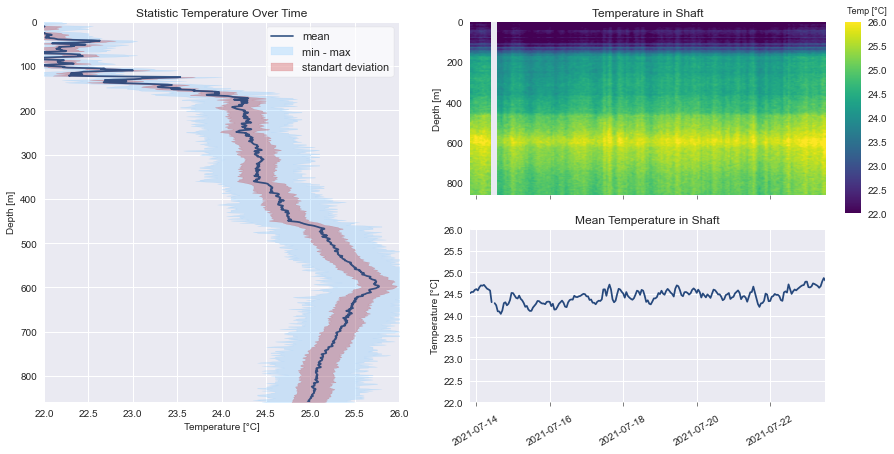

Date range before EGRT
20 dates with nan have been added


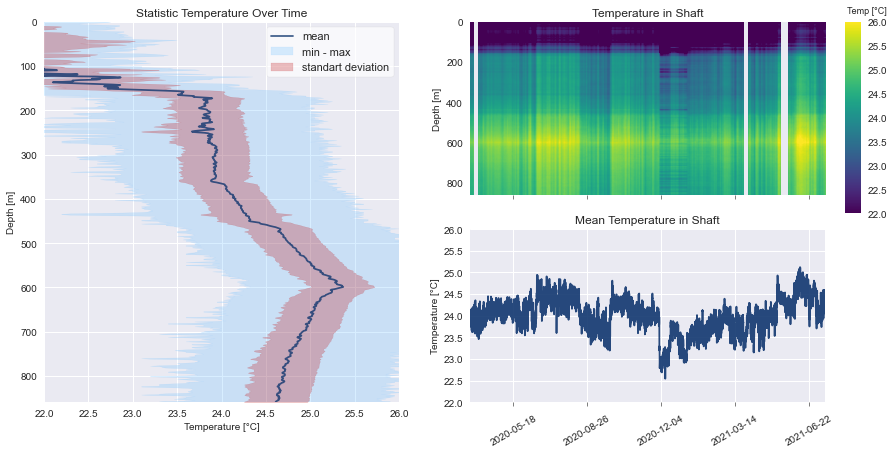

Date range after EGRT
0 dates with nan have been added


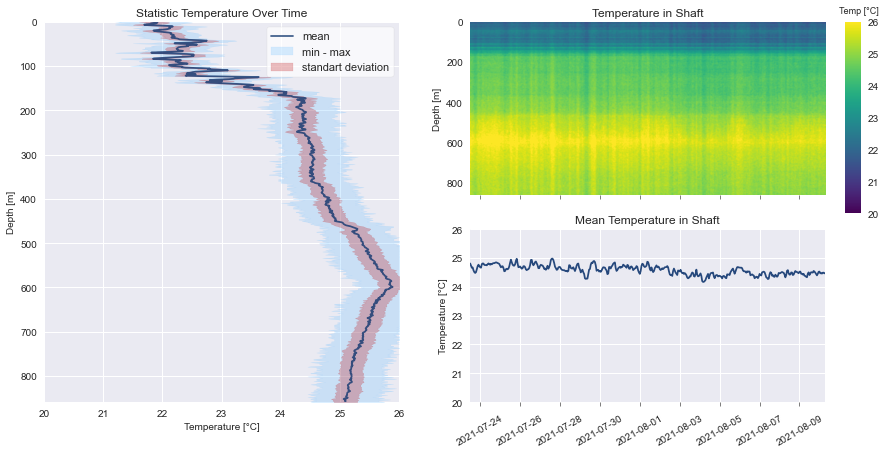

In [31]:
if compare_to_egrt:
    # Compare: Date range at EGRT
    print("Date range at EGRT")
    statistic_plot(data_shaft=shaft)
    plt.show()

    # Compare: Date range before EGRT
    print("Date range before EGRT")
    statistic_plot(data_shaft=shaft,date_min_max=[20400,61650],c="1",temp_ax_min=22, temp_ax_max=26, sample_hours = 1)
    plt.show()

    # Compare: Date range after EGRT
    print("Date range after EGRT")
    statistic_plot(data_shaft=shaft,date_min_max=[62200,63000],c="1",temp_ax_min=20, temp_ax_max=26, sample_hours = 1)
    plt.show()